In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import shapely

# Joining Crash Data to Node Graph

The goal here is to take each crash for which we have a latitude and a longitude and associate it with a specific node from the graph subset we're using.

If any crash event does not have a node that is associated with it, then we drop the crash.

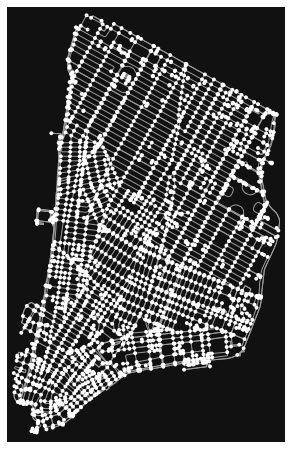

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [12]:
# We load the graph whose nodes we intend to use:
G = ox.io.load_graphml('../../data/mnh_below_34th.graphml')
ox.plot_graph(G)

In [4]:
crash_df = pd.read_csv('../../data/crash_data_normalized.csv')

In [5]:
from tqdm.notebook import tqdm
# This is the distance from a crash to its nearest node beyond which we assume
# that the crash occurred outside of our graph and isn't really matched to that node.
THRESHOLD_DIST_M = 100
nearest_nodes = pd.DataFrame(columns=['NODE_ID', 'NODE_DIST_FROM_CRASH_M', 'NODE_LATITUDE', 'NODE_LONGITUDE'])

for i, crash in tqdm(crash_df.iterrows(), total=crash_df.shape[0]):
    nn_id, dist = ox.distance.nearest_nodes(G, crash.LONGITUDE, crash.LATITUDE, return_dist=True)
    if dist > THRESHOLD_DIST_M:
        continue
    nn = G.nodes[nn_id]
    nearest_nodes.loc[i] = {
        'NODE_ID': nn_id,
        'NODE_DIST_FROM_CRASH_M': dist,
        'NODE_LATITUDE': nn['y'],
        'NODE_LONGITUDE': nn['x'],
    }
    
nearest_nodes

  0%|          | 0/39495 [00:00<?, ?it/s]

,NODE_ID,NODE_DIST_FROM_CRASH_M,NODE_LATITUDE,NODE_LONGITUDE
34,42437644,2.897338,40.748439,-73.984532
57,42442895,22.200879,40.740422,-73.979096
59,486867432,7.759233,40.719681,-73.992175
66,42434807,12.272091,40.746618,-73.993813
74,42454798,1.284833,40.706146,-74.006016
...,...,...,...,...
39417,42453104,3.675021,40.731964,-73.990203
39421,42442255,1.395292,40.722669,-73.997975
39430,42429754,7.054891,40.719907,-73.992918
39433,42436142,1.343927,40.735732,-74.006801


In [6]:
# Append the columns from the node df, including only the rows that have an associated node
crash_df_with_nodes = pd.concat((crash_df, nearest_nodes), join='inner', axis=1)

crash_df_with_nodes

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,...,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,NODE_ID,NODE_DIST_FROM_CRASH_M,NODE_LATITUDE,NODE_LONGITUDE
34,293,2021-04-16,18:40,NaN,NaN,40.748436,-73.984566,"(40.748436, -73.984566)",5 AVENUE,NaN,...,4408250,Sedan,E-Bike,NaN,NaN,NaN,42437644,2.897338,40.748439,-73.984532
57,501,2021-04-01,15:10,MANHATTAN,10016.0,40.740580,-73.978935,"(40.74058, -73.978935)",NaN,NaN,...,4408084,Sedan,Bike,NaN,NaN,NaN,42442895,22.200879,40.740422,-73.979096
59,507,2021-04-10,11:15,MANHATTAN,10002.0,40.719750,-73.992165,"(40.71975, -73.992165)",FORSYTH STREET,DELANCEY STREET,...,4408030,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,486867432,7.759233,40.719681,-73.992175
66,605,2021-04-13,17:15,MANHATTAN,10001.0,40.746520,-73.993880,"(40.74652, -73.99388)",NaN,NaN,...,4408083,Sedan,NaN,NaN,NaN,NaN,42434807,12.272091,40.746618,-73.993813
74,680,2021-04-15,12:12,MANHATTAN,10005.0,40.706142,-74.006030,"(40.706142, -74.00603)",WATER STREET,MAIDEN LANE,...,4407694,Sedan,NaN,NaN,NaN,NaN,42454798,1.284833,40.706146,-74.006016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39417,415569,2019-01-03,10:30,NaN,NaN,40.731995,-73.990220,"(40.731995, -73.99022)",4 AVENUE,NaN,...,4061280,Taxi,Bike,NaN,NaN,NaN,42453104,3.675021,40.731964,-73.990203
39421,415638,2019-01-04,19:00,MANHATTAN,10012.0,40.722660,-73.997986,"(40.72266, -73.997986)",SPRING STREET,CROSBY STREET,...,4063005,Sedan,Bike,NaN,NaN,NaN,42442255,1.395292,40.722669,-73.997975
39430,415779,2019-01-03,14:30,MANHATTAN,10002.0,40.719970,-73.992905,"(40.71997, -73.992905)",CHRYSTIE STREET,DELANCEY STREET,...,4066713,Sedan,NaN,NaN,NaN,NaN,42429754,7.054891,40.719907,-73.992918
39433,415812,2019-01-03,0:27,MANHATTAN,10014.0,40.735720,-74.006805,"(40.73572, -74.006805)",GREENWICH STREET,WEST 11 STREET,...,4062317,Taxi,Bike,NaN,NaN,NaN,42436142,1.343927,40.735732,-74.006801


In [7]:
# Let's try displaying the number of crashes per intersection now.

# First group by the NODE_ID and count the values
crash_counts_by_node = crash_df_with_nodes.groupby('NODE_ID').size()

# Then we want to make this fully populated with respect to the set of nodes in the graph
def saturate_nodes(G, s):
    for node_id in G.nodes:
        if node_id in s.index:
            continue
        else:
            s.loc[node_id] = 0
    return s
crash_counts_by_node = saturate_nodes(G, crash_counts_by_node)

crash_counts_by_node.sort_values()

NODE_ID
42436024       0
1919595928     0
1927758595     0
1989931095     0
1989931098     0
              ..
42437654      20
5131026388    21
42429754      21
42429773      21
42452067      25
Length: 2587, dtype: int64

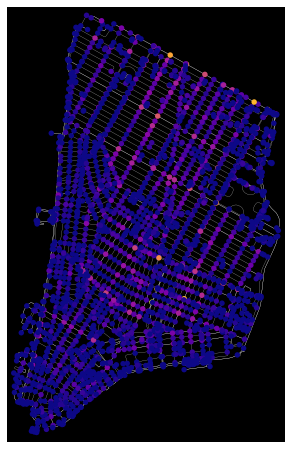

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [8]:
# Now we set the node attributes to be this crash count
nx.set_node_attributes(G, dict(crash_counts_by_node), "n_crashes")
# Now we map these to colors
nc = ox.plot.get_node_colors_by_attr(G, "n_crashes", cmap="plasma")
# Now we plot the graph with the colors
ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)

It looks like we're getting a lot of crashes clumped into the edges here. Let's display the mean distance from the crash to the nodes on this map instead to get an idea of the edge effects here.

In [9]:
saturate_nodes(G, crash_df_with_nodes.groupby('NODE_ID').mean()['NODE_DIST_FROM_CRASH_M'])

NODE_ID
42421877       1.348756
42421889       1.995584
42421941       1.000898
42422026       1.569411
42422028      14.608369
                ...    
9143569898     0.000000
9143574624     0.000000
9149294704     0.000000
9165725162     0.000000
9165725163     0.000000
Name: NODE_DIST_FROM_CRASH_M, Length: 2587, dtype: float64

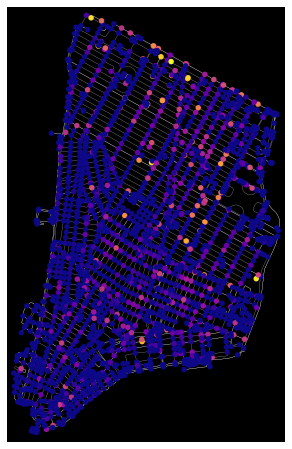

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
nx.set_node_attributes(G, dict(saturate_nodes(G, crash_df_with_nodes.groupby('NODE_ID').mean()['NODE_DIST_FROM_CRASH_M'])), 'dist_from_crash')
nc = ox.plot.get_node_colors_by_attr(G, 'dist_from_crash', cmap='plasma')
ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)

From the above, it looks like although the edges are definitely picking up some crashes that would probably be better associated with nodes that are being clipped from the map, they are not altogether dramatically worse in this regard than many of the nodes centered in the graph. We'll keep it as-is.

Let's write the data we have to a CSV:

In [11]:
crash_df_with_nodes.to_csv('../../data/crash_data_normalized_with_node_graph.csv')